5. 회원 탈퇴를 예측하는 테크닉 

테크닉 41. 데이터를 읽어 들이고 이용 데이터를 수정하자 

In [1]:
# 데이터 불러오기 
import pandas as pd 
customer = pd.read_csv("customer_join.csv") # 3장에서 작성한 이용 이력을 포함한 고객 데이터 
uselog_months = pd.read_csv("use_log_months.csv") # 4장에서 작성한 이용 이력을 연월/고객별로 집계한 데이터 

In [2]:
# 6개월분의 데이터로부터 이용 횟수를 예측하는 경우, 가입 5개월 이내인 회원의 탈퇴는 예측할 수 없음 
# 불과 몇 개월 만에 그만둔 회원도 많기 때문에 과거 6개월분의 데이터를 이용한 예측은 의미가 없다. 
# 따라서 이달과 1개월 전의 이용 횟수를 집계한 데이터를 작성한다. 

year_months = list(uselog_months["연월"].unique())
uselog = pd.DataFrame()
for i in range(1, len(year_months)):
    tmp = uselog_months.loc[uselog_months["연월"]==year_months[i]]
    tmp.rename(columns={"count":"count_0"}, inplace=True)
    tmp_before = uselog_months.loc[uselog_months["연월"] == year_months[i-1]]
    del tmp_before["연월"]
    tmp_before.rename(columns={"count":"count_1"}, inplace=True)
    tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    uselog = pd.concat([uselog, tmp], ignore_index=True)
uselog

C:\Users\82109\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\82109\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\82109\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\82109\anacond

,연월,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0
...,...,...,...,...
33846,201903,TS995853,8,11.0
33847,201903,TS998593,8,7.0
33848,201903,TS999079,3,2.0
33849,201903,TS999231,6,6.0


테크닉 42. 탈퇴 전월의 탈퇴 고객 데이터를 작성하자

In [3]:
# 탈퇴를 예측하는 목적은 탈퇴를 미연의 방지하는 것 
# 이 스포츠 센터에서는 월말까지 탈퇴 신청을 해야 다음 달 말에 탈퇴할 수 있다. 
# 그러므로 탈퇴 월과 1개월 전의 데이터로부터 탈퇴 신청을 할 확률을 예측해야 한다. 

from dateutil.relativedelta import relativedelta
exit_customer = customer.loc[customer["is_deleted"]==1]
exit_customer["exit_date"] = None
exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
for i in range(len(exit_customer)):
    exit_customer["exit_date"].iloc[i] = exit_customer["end_date"].iloc[i] - relativedelta(months=1)
exit_customer["연월"] = pd.to_datetime(exit_customer["exit_date"]).dt.strftime("%Y%m")
uselog["연월"] = uselog["연월"].astype(str)
exit_uselog = pd.merge(uselog, exit_customer, on=["customer_id", "연월"], how="left")
print(len(uselog))
exit_uselog

<ipython-input-3-3fccb2787bc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["exit_date"] = None
<ipython-input-3-3fccb2787bc0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
C:\Users\82109\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

33851


<ipython-input-3-3fccb2787bc0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["연월"] = pd.to_datetime(exit_customer["exit_date"]).dt.strftime("%Y%m")


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33846,201903,TS995853,8,11.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33847,201903,TS998593,8,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33848,201903,TS999079,3,2.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33849,201903,TS999231,6,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 결합한 데이터는 탈퇴한 회우너의 탈퇴 전월의 데이터뿐이므로 결측치가 많다. 
# 결측치가 없는 데이터만 남기고 나머지 삭제 
exit_uselog = exit_uselog.dropna(subset=["name"])
print(len(exit_uselog))

1104


In [5]:
print(len(exit_uselog["customer_id"].unique())) # 중복 확인 

1104


In [6]:
exit_uselog

,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,2_일반,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30 00:00:00
57,201805,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,2_일반,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30 00:00:00
110,201805,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,2_일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30 00:00:00
128,201805,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,2_일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30 00:00:00
147,201805,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,2_일반,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30758,201902,TS645212,4,2.0,XXXX,C03,F,2018-03-01,2019-03-31,CA1,...,6000.0,2_일반,4.500000,4.5,7.0,1.0,0.0,2019-03-31,12.0,2019-02-28 00:00:00
30787,201902,TS741703,5,6.0,XXXX,C03,M,2018-12-08,2019-03-31,CA3,...,6000.0,1_입회비무료,6.250000,6.0,8.0,5.0,0.0,2019-03-31,3.0,2019-02-28 00:00:00
30827,201902,TS859258,1,3.0,XXXXX,C02,F,2018-12-07,2019-03-31,CA3,...,7500.0,1_입회비무료,2.500000,2.0,5.0,1.0,0.0,2019-03-31,3.0,2019-02-28 00:00:00
30842,201902,TS886985,5,3.0,XXX,C02,F,2018-03-01,2019-03-31,CA1,...,7500.0,2_일반,4.250000,4.0,7.0,2.0,1.0,2019-03-31,12.0,2019-02-28 00:00:00


테크닉 43. 지속 회원의 데이터를 작성하자.

In [7]:
# 지속 회원은 탈퇴 월이 없으므로 어떤 연월의 데이터를 사용해도 무방하다. 
# 지속 회원을 추출한 후 uselog 데이터에 결합하자 
conti_customer = customer.loc[customer["is_deleted"]==0]
conti_uselog = pd.merge(uselog, conti_customer, on=["customer_id"], how="left")
print(len(conti_uselog))
conti_uselog = conti_uselog.dropna(subset=["name"]) # 결측치 제거 
print(len(conti_uselog))

33851
27422


In [8]:
# 데이터를 섞고 중복을 제거하자 
conti_uselog = conti_uselog.sample(frac=1).reset_index(drop=True)
conti_uselog = conti_uselog.drop_duplicates(subset="customer_id")
print(len(conti_uselog))
conti_uselog

2842


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201902,GD100850,7,6.0,XXXX,C01,M,2017-02-01,NaN,CA1,...,0_종일,10500.0,2_일반,5.166667,5.0,7.0,4.0,1.0,2019-04-30,26.0
1,201811,GD099906,4,6.0,XXXXX,C02,F,2016-04-01,NaN,CA1,...,1_주간,7500.0,2_일반,4.333333,4.0,7.0,3.0,1.0,2019-04-30,36.0
2,201806,HD749546,5,4.0,XXXXX,C02,F,2017-01-01,NaN,CA1,...,1_주간,7500.0,2_일반,5.333333,5.0,7.0,3.0,1.0,2019-04-30,27.0
3,201903,TS717160,5,3.0,XXX,C02,F,2016-09-01,NaN,CA1,...,1_주간,7500.0,2_일반,5.000000,4.5,8.0,3.0,1.0,2019-04-30,31.0
4,201811,GD376049,7,3.0,XXXX,C02,F,2017-12-01,NaN,CA3,...,1_주간,7500.0,1_입회비무료,6.916667,7.0,11.0,3.0,1.0,2019-04-30,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26744,201903,OA776184,8,NaN,XXXXX,C01,M,2019-03-01,NaN,CA1,...,0_종일,10500.0,2_일반,8.000000,8.0,8.0,8.0,1.0,2019-04-30,1.0
26809,201903,HD078960,11,NaN,XXXX,C03,M,2019-03-10,NaN,CA1,...,2_야간,6000.0,2_일반,11.000000,11.0,11.0,11.0,0.0,2019-04-30,1.0
26953,201903,TS028201,9,NaN,XXXXX,C01,M,2019-03-05,NaN,CA1,...,0_종일,10500.0,2_일반,9.000000,9.0,9.0,9.0,1.0,2019-04-30,1.0
27051,201903,PL207100,11,NaN,XXXXXX,C01,M,2019-03-12,NaN,CA1,...,0_종일,10500.0,2_일반,11.000000,11.0,11.0,11.0,0.0,2019-04-30,1.0


In [9]:
# 지속 회원 데이터와 탈퇴 회원 데이터를 세로로 결합하기 
predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index=True)
print(len(predict_data))
predict_data

3946


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201902,GD100850,7,6.0,XXXX,C01,M,2017-02-01,NaN,CA1,...,10500.0,2_일반,5.166667,5.0,7.0,4.0,1.0,2019-04-30,26.0,NaN
1,201811,GD099906,4,6.0,XXXXX,C02,F,2016-04-01,NaN,CA1,...,7500.0,2_일반,4.333333,4.0,7.0,3.0,1.0,2019-04-30,36.0,NaN
2,201806,HD749546,5,4.0,XXXXX,C02,F,2017-01-01,NaN,CA1,...,7500.0,2_일반,5.333333,5.0,7.0,3.0,1.0,2019-04-30,27.0,NaN
3,201903,TS717160,5,3.0,XXX,C02,F,2016-09-01,NaN,CA1,...,7500.0,2_일반,5.000000,4.5,8.0,3.0,1.0,2019-04-30,31.0,NaN
4,201811,GD376049,7,3.0,XXXX,C02,F,2017-12-01,NaN,CA3,...,7500.0,1_입회비무료,6.916667,7.0,11.0,3.0,1.0,2019-04-30,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,201902,TS645212,4,2.0,XXXX,C03,F,2018-03-01,2019-03-31 00:00:00,CA1,...,6000.0,2_일반,4.500000,4.5,7.0,1.0,0.0,2019-03-31,12.0,2019-02-28 00:00:00
3942,201902,TS741703,5,6.0,XXXX,C03,M,2018-12-08,2019-03-31 00:00:00,CA3,...,6000.0,1_입회비무료,6.250000,6.0,8.0,5.0,0.0,2019-03-31,3.0,2019-02-28 00:00:00
3943,201902,TS859258,1,3.0,XXXXX,C02,F,2018-12-07,2019-03-31 00:00:00,CA3,...,7500.0,1_입회비무료,2.500000,2.0,5.0,1.0,0.0,2019-03-31,3.0,2019-02-28 00:00:00
3944,201902,TS886985,5,3.0,XXX,C02,F,2018-03-01,2019-03-31 00:00:00,CA1,...,7500.0,2_일반,4.250000,4.0,7.0,2.0,1.0,2019-03-31,12.0,2019-02-28 00:00:00


테크닉 44. 예측할 달의 재적 기간을 작성하자

In [10]:
# 시간적 요소가 들어간 데이터를 변수로 이용하는 것은 좋은 접근이라고 할 수 있다. 
# 재적 기간 열을 추가하자 
predict_data["period"] = 0
predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = int(delta.years * 12 + delta.months)
predict_data

<ipython-input-10-9305743e4462>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = int(delta.years * 12 + delta.months)


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,period,now_date
0,201902,GD100850,7,6.0,XXXX,C01,M,2017-02-01,NaN,CA1,...,5.166667,5.0,7.0,4.0,1.0,2019-04-30,26.0,NaN,24,2019-02-01
1,201811,GD099906,4,6.0,XXXXX,C02,F,2016-04-01,NaN,CA1,...,4.333333,4.0,7.0,3.0,1.0,2019-04-30,36.0,NaN,31,2018-11-01
2,201806,HD749546,5,4.0,XXXXX,C02,F,2017-01-01,NaN,CA1,...,5.333333,5.0,7.0,3.0,1.0,2019-04-30,27.0,NaN,17,2018-06-01
3,201903,TS717160,5,3.0,XXX,C02,F,2016-09-01,NaN,CA1,...,5.000000,4.5,8.0,3.0,1.0,2019-04-30,31.0,NaN,30,2019-03-01
4,201811,GD376049,7,3.0,XXXX,C02,F,2017-12-01,NaN,CA3,...,6.916667,7.0,11.0,3.0,1.0,2019-04-30,16.0,NaN,11,2018-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,201902,TS645212,4,2.0,XXXX,C03,F,2018-03-01,2019-03-31 00:00:00,CA1,...,4.500000,4.5,7.0,1.0,0.0,2019-03-31,12.0,2019-02-28 00:00:00,11,2019-02-01
3942,201902,TS741703,5,6.0,XXXX,C03,M,2018-12-08,2019-03-31 00:00:00,CA3,...,6.250000,6.0,8.0,5.0,0.0,2019-03-31,3.0,2019-02-28 00:00:00,1,2019-02-01
3943,201902,TS859258,1,3.0,XXXXX,C02,F,2018-12-07,2019-03-31 00:00:00,CA3,...,2.500000,2.0,5.0,1.0,0.0,2019-03-31,3.0,2019-02-28 00:00:00,1,2019-02-01
3944,201902,TS886985,5,3.0,XXX,C02,F,2018-03-01,2019-03-31 00:00:00,CA1,...,4.250000,4.0,7.0,2.0,1.0,2019-03-31,12.0,2019-02-28 00:00:00,11,2019-02-01


테크닉 45. 결측치를 제거하자.

In [18]:
# 결측치가 있으면 머신러닝을 할 수 없다. 
# 그래서 결측치는 제거하거나 채워 넣어야 한다. 

In [11]:
# 결측치의 수 파악하기 
predict_data.isna().sum()

# end_date과 exit_date은 탈퇴 고객이므로 두고, count_1에 위치하는 값이 결측치이다. 

연월                      0
customer_id             0
count_0                 0
count_1               262
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
period                  0
now_date                0
dtype: int64

In [12]:
# count_1의 결손된 데이터 제거하기 
predict_data = predict_data.dropna(subset=["count_1"]) # 특정 칼럼을 지정(subset)해 결측치 제거
predict_data.isna().sum()

연월                      0
customer_id             0
count_0                 0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2632
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2632
period                  0
now_date                0
dtype: int64

+) 원핫 인코딩 (One-Hot-Encoding)

In [ ]:
# 문자열을 숫자로 변환하는 방법으로...
# 숫자로 대체하는 방법 
# ex) 컴퓨터 1, 마우스 2, 키보드 3 등 (그러나 크기 비교, 평균 등 값이 이상하게 나온다)
# 데이터의 연속성에 대한 문제 발생 - 연속적인 특성, 순서가 없는 데이터이기 때문에 발생하는 것

# One-Hot-Encoding 기법의 필요 

In [21]:
# ex) 
data_dic = {'label':['Apple', 'Samsung', 'LG', 'Samsung']}
df = pd.DataFrame(data_dic)
df

,label
0,Apple
1,Samsung
2,LG
3,Samsung


In [22]:
# One-Hot-Encoding
# pandas 사용 

pd_encoded = pd.get_dummies(df['label'])
print(pd_encoded)

   Apple  LG  Samsung
0      1   0        0
1      0   0        1
2      0   1        0
3      0   0        1


In [24]:
# sklearn 사용 
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()

In [25]:
skl_encoded = oh.fit_transform(df)

In [26]:
print(skl_encoded)

# 1이 나오는 위치를 표현. 즉 0이 아닌 값의 위치를 의미 
# 사람이 보기엔 안좋아도 컴퓨터가 처리하기엔 용이하다. 

  (0, 0)	1.0
  (1, 2)	1.0
  (2, 1)	1.0
  (3, 2)	1.0


테크닉 46. 문자열 변수를 처리할 수 있게 가공하자. 

In [14]:
target_col = ["campaign_name", "class_name", "gender", "count_1", "routine_flg", "period", "is_deleted"]
predict_data = predict_data[target_col]
predict_data

,campaign_name,class_name,gender,count_1,routine_flg,period,is_deleted
0,2_일반,0_종일,M,6.0,1.0,24,0.0
1,2_일반,1_주간,F,6.0,1.0,31,0.0
2,2_일반,1_주간,F,4.0,1.0,17,0.0
3,2_일반,1_주간,F,3.0,1.0,30,0.0
4,1_입회비무료,1_주간,F,3.0,1.0,11,0.0
...,...,...,...,...,...,...,...
3941,2_일반,2_야간,F,2.0,0.0,11,1.0
3942,1_입회비무료,2_야간,M,6.0,0.0,1,1.0
3943,1_입회비무료,1_주간,F,3.0,0.0,1,1.0
3944,2_일반,1_주간,F,3.0,1.0,11,1.0


In [15]:
predict_data = pd.get_dummies(predict_data)
predict_data

,count_1,routine_flg,period,is_deleted,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,campaign_name_2_일반,class_name_0_종일,class_name_1_주간,class_name_2_야간,gender_F,gender_M
0,6.0,1.0,24,0.0,0,0,1,1,0,0,0,1
1,6.0,1.0,31,0.0,0,0,1,0,1,0,1,0
2,4.0,1.0,17,0.0,0,0,1,0,1,0,1,0
3,3.0,1.0,30,0.0,0,0,1,0,1,0,1,0
4,3.0,1.0,11,0.0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3941,2.0,0.0,11,1.0,0,0,1,0,0,1,1,0
3942,6.0,0.0,1,1.0,0,1,0,0,0,1,0,1
3943,3.0,0.0,1,1.0,0,1,0,0,1,0,1,0
3944,3.0,1.0,11,1.0,0,0,1,0,1,0,1,0


In [17]:
# 필요없는 칼럼 삭제. 내가 만든 데이터셋이 책과 조금 다름... 
del predict_data["campaign_name_2_일반"]
del predict_data["class_name_2_야간"]
del predict_data["gender_M"]

predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,class_name_0_종일,class_name_1_주간,gender_F
0,6.0,1.0,24,0.0,0,0,1,0,0
1,6.0,1.0,31,0.0,0,0,0,1,1
2,4.0,1.0,17,0.0,0,0,0,1,1
3,3.0,1.0,30,0.0,0,0,0,1,1
4,3.0,1.0,11,0.0,0,1,0,1,1


테크닉 47. 의사결정 트리를 사용해서 탈퇴 예측 모델을 구축하자.

In [18]:
# 의사결정 트리를 사용해 모델 구축하기 
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection

In [19]:
# 탈퇴 데이터(1104개)와 유지 데이터(2842개)의 개수 정리 
# 유지 데이터에서 임의로 1104건을 추출해 비율이 50:50이 되게 한다. 

exit = predict_data.loc[predict_data["is_deleted"] == 1] 
conti = predict_data.loc[predict_data["is_deleted"] == 0].sample(len(exit))

In [21]:
X = pd.concat([exit, conti], ignore_index=True) # 앞에서 나눈 데이터를 결합해 X에 저장 
y = X["is_deleted"] # is_deleted 칼럼을 목적변수 y에 저장
del X["is_deleted"] # X에서 is_deleted 열 제거 
# 학습 데이터와 평가 데이터로 나누기. 범위 지정이 없으므로 자동으로 75%, 25%가 적용  
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

In [22]:
model = DecisionTreeClassifier(random_state = 0) # 모델 생성 
model.fit(X_train, y_train) # 학습용 모델 구축(fit) 
y_test_pred = model.predict(X_test) # 평가 데이터로 확인. 1은 탈퇴, 0은 유지 
print(y_test_pred)

[1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.

In [23]:
# 실제 정답과 비교하기 위해 실제 값 y_test와 함께 데이터프레임으로 저장 
results_test = pd.DataFrame({"y_test":y_test, "y_pred":y_test_pred})
results_test

,y_test,y_pred
523,1.0,1.0
144,1.0,1.0
1373,0.0,0.0
910,1.0,1.0
1275,0.0,0.0
...,...,...
577,1.0,1.0
799,1.0,1.0
167,1.0,1.0
483,1.0,1.0


테크닉 48. 예측 모델을 평가하고 모델을 튜닝해 보자

In [24]:
# results_test를 집계해 정답률 계산하기 
# 정답 수: results_test 데이터의 y_test와 y_pred가 일치하는 개수 / 전체 데이터 개수 

# results_test 데이터의 y_test 열과 y_pred 열이 일치하는 데이터의 개수를 len으로 계산
correct = len(results_test.loc[results_test["y_test"]==results_test["y_pred"]])
data_count = len(results_test) # 전체 데이터 개수 
score_test = correct / data_count # 정답률 출력 
print(score_test)

0.8821292775665399


In [25]:
# 각각의 데이터를 이용했을 때의 정확도 계산해보기 
# score를 이용하면 정확도를 간단히 계산할 수 있다. 
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

# 학습용 데이터에 너무 맞춘 과적합 경향을 보임 

0.8821292775665399
0.9790874524714829


In [26]:
# 과적합의 경우 데이터 늘리기, 변수 재검토, 모델의 파라미터 변경 등과 같은 방법을 적용한다. 
# 의사결정 트리는 0, 1로 분할할 수 있는 설명 변수와 그 조건에 맞는 트리 구조를 찾는 방법이므로 
# 트리의 깊이를 얕게 하면 모델을 단순화할 수 있다. 

X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

In [27]:
model = DecisionTreeClassifier(random_state=0, max_depth=5)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.8916349809885932
0.9347275031685678


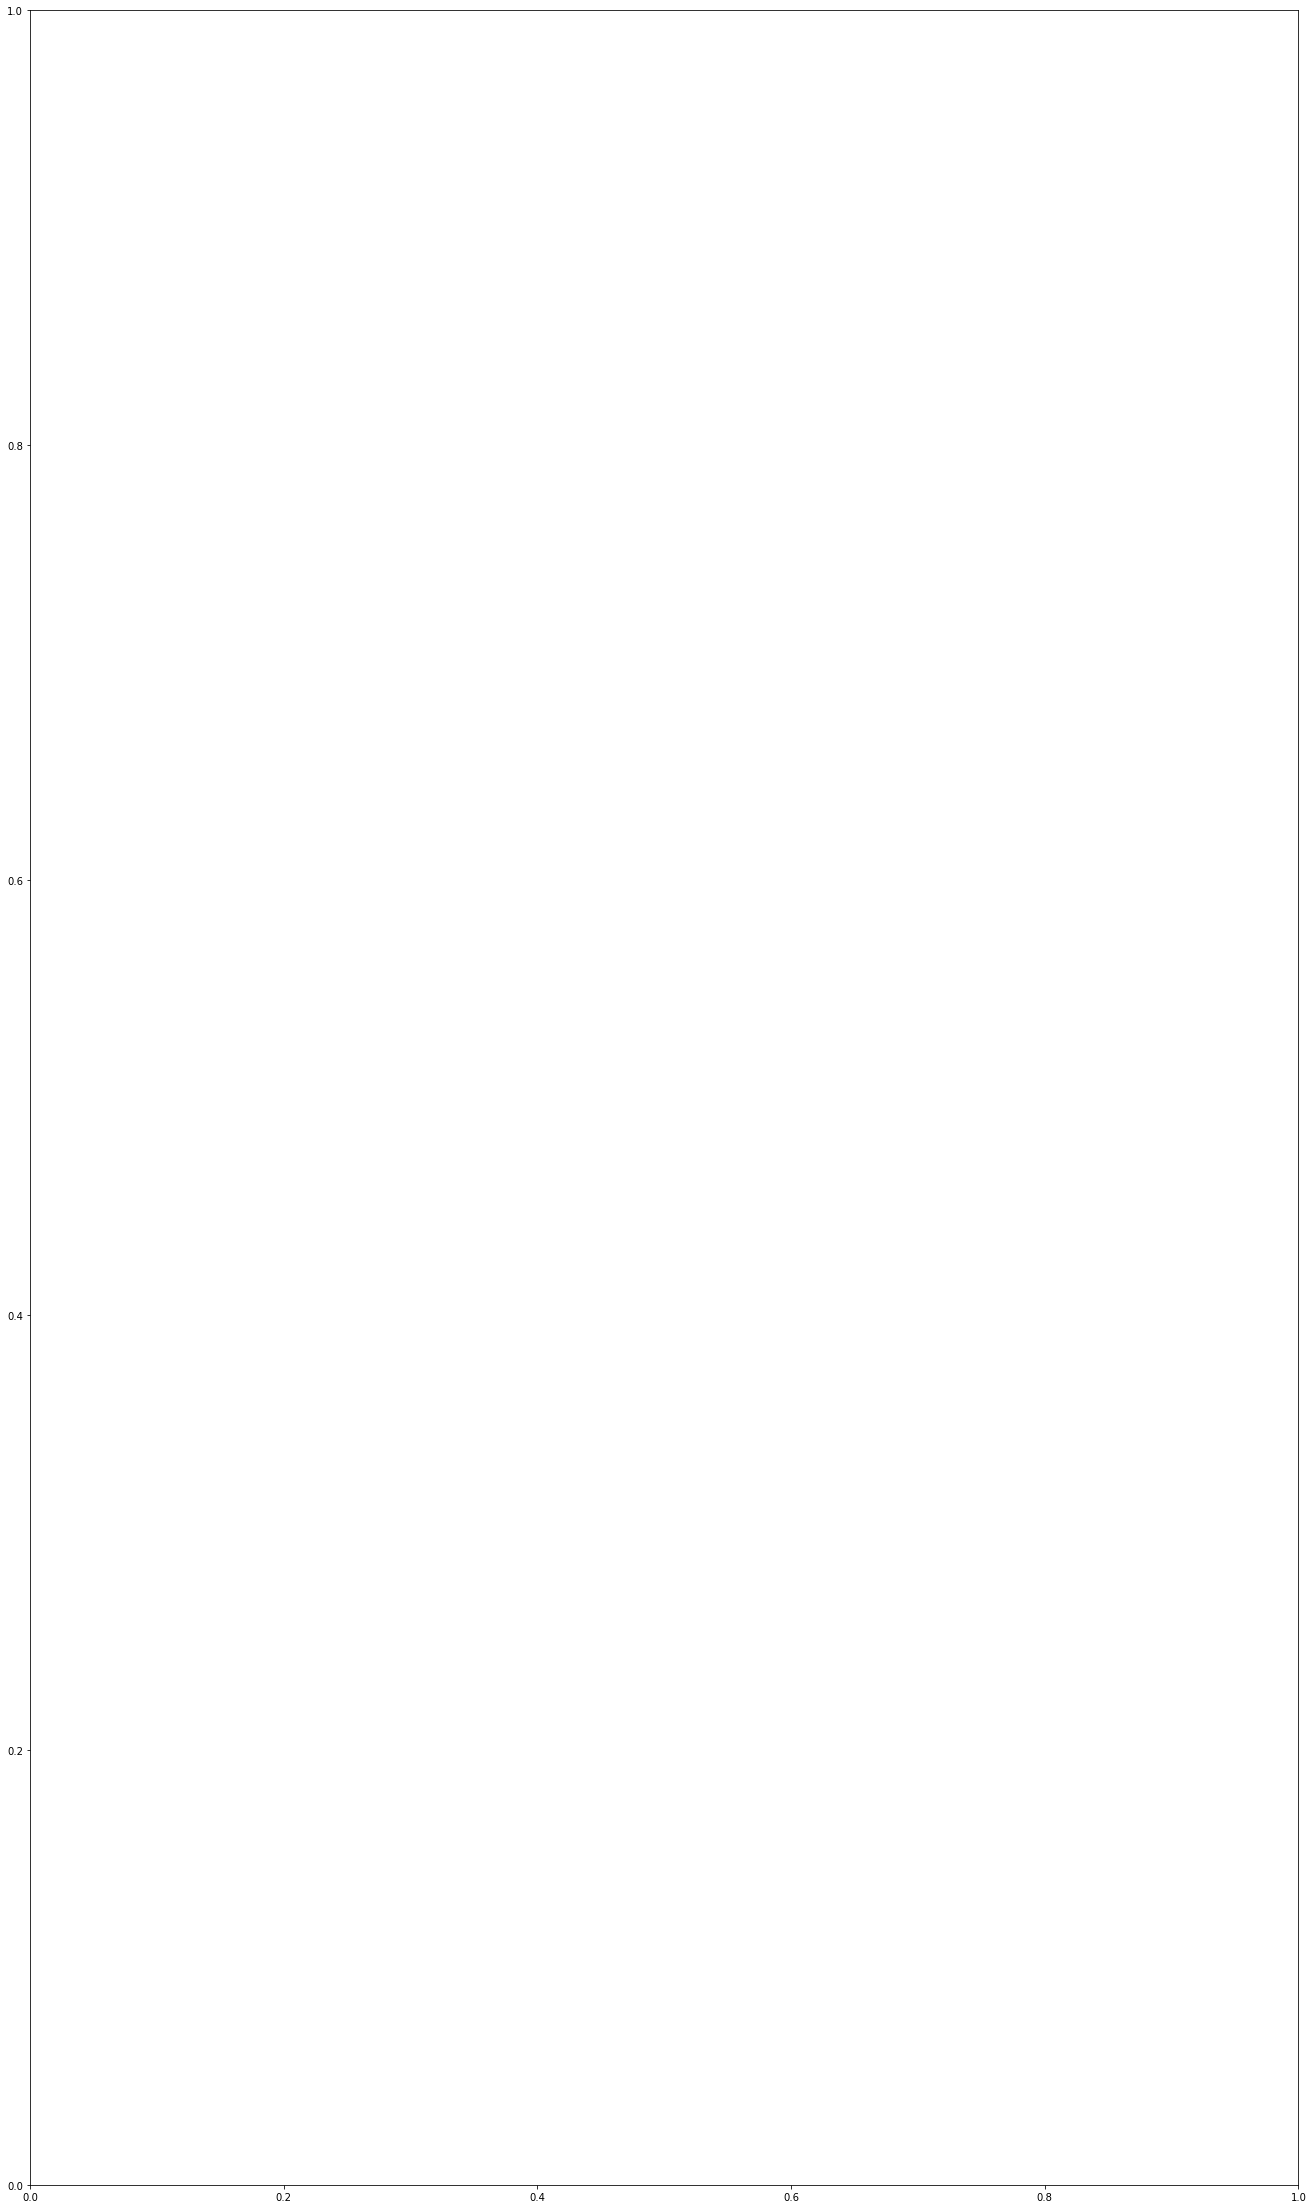

In [36]:
# 트리 그리기 
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(50,40))
ax = fig.add_subplot(1,2,1)

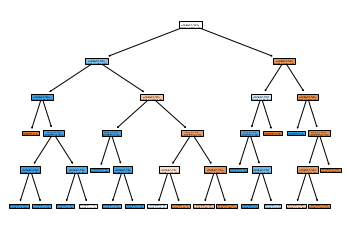

In [32]:
from sklearn import tree
tree.plot_tree(model, impurity = False, filled=True)
plt.show() # 위만 실행하면 글이 줄줄이 나온 뒤 모형이 그려진다;; 

테크닉 49. 모델에 기여하는 변수를 확인하자 

In [37]:
# 모델에 기여하는 변수 확인하기 

# 테크닉 39와 같이 변수와 중요도를 데이터프레임에 저장하지만 
# 변수의 기여율을 출력하는 함수가 조금 다르다. 
importance = pd.DataFrame({"feature_names": X.columns, "coefficient": model.feature_importances_})
importance

,feature_names,coefficient
0,count_1,0.326578
1,routine_flg,0.131945
2,period,0.534710
3,campaign_name_0_입회비반액할인,0.000000
4,campaign_name_1_입회비무료,0.005306
5,class_name_0_종일,0.001461
6,class_name_1_주간,0.000000
7,gender_F,0.000000


테크닉 50. 회원 탈퇴를 예측하자.

In [38]:
# 모델을 작성할 때 사용한 설명 변수를 참고로 예측을 위한 데이터 작성 

# 1개월 전의 이용 횟수를 3회, 정기 이용, 재적 기간 10, 캠페인 구분은 가입비 무료, 
# 회원 구분은 종일, 성별은 남성으로 해서 작성해 보자.
count_1 = 3
routing_flg = 1
period = 10
campaign_name = "입회비무료"
class_name = "종일" 
gender = "M"

In [40]:
# 변수가 정의되었으니 데이터를 가공 
# 카테고리 변수를 이용하므로 조금 복잡함 

# 카테고리 변수를 if 문으로 분기하면서 더미 변수로 작성, 이를 1개의 리스트에 저장 
# 예측은 1, 0 뿐만아니라 확률로 나타낼 수도 있다. 
if campaign_name == "입회비반값할인":
    campaign_name_list = [1, 0]
elif campaign_name == "입회비무료":
    campaign_name_list = [0, 1] 
elif campaign_name == "일반":
    campaign_name_list = [0, 0]
if class_name == "종일":
    class_name_list = [1, 0]
elif class_name == "주간":
    class_name_list = [0, 1]
elif class_name == "야간":
    class_name_list = [0, 0] 
if gender == "F":
    gender_list = [1]
elif gender == "M":
    gender_list = [0]
input_data = [count_1, routing_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)

print(model.predict([input_data]))
print(model.predict_proba([input_data])) # 앞(탈퇴)이 0.9% 확률, 뒤(유지)가 99% 확률

[1.]
[[0.00896861 0.99103139]]


In [56]:
# 변수를 바꿔가며 예측을 해보자. 
# 실제로는 구축한 모델을 시스템화해 이용하는 경우가 많다. 
# 예측모델을 구축하는 것은 신속하게 자동으로 탈퇴 회원을 찾을 수 있어 
# 인간의 감각뿐만 아니라 데이터를 기반으로 판단할 수 있게 해준다. 
# 어디까지나 최후의 판단은 인간이 하겠지만, 예측 모델의 예측 결과를 
# 현명하게 활용함으로써 비즈니스를 극적으로 변화시킬 수 있다. 